<a href="https://nbviewer.jupyter.org/github/project-ida/phonons/blob/anthony-sandbox/Strings%20Part%202.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

In [1]:
# loading some common python libraries

import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import Image
from IPython.core.display import HTML 
import sympy as sp
#from google.colab.output._publish import javascript
mathjaxurl = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
sp.init_printing(use_latex='mathjax') 
import matplotlib.patches as patches
import pandas as pd

In [2]:
class object:
    def __init__(self, mass = 1, x0 = 0, v0 = 0, a0 = 0, dt = 0.0001):
        #Establishing the parameters of an object
        self.mass = mass
        self.position = x0
        self.velocity = v0
        self.acceleration = a0
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.dt = dt
        
        #self.force is a list of all of the different forces that are acting on the object
        self.forces = []
        
        #self.xhistory is all of the different positions the object has gone through; the purpose of this is for graphing
        self.xhistory = []
        
        #Keep track of initial conditions for resets
        self.xstart = x0
        self.vstart = v0
        self.astart = a0

    def xstep(self):
        self.xhistory.append(self.position)
        self.position = self.position + self.velocity*self.dt + 0.5*self.acceleration*self.dt**2
    
    def vstep(self):
        a_old = self.acceleration
        self.Newton()
        self.velocity = self.velocity + 0.5 * (a_old + self.acceleration) * self.dt
        self.energy = 0.5 * self.mass * (self.velocity) ** 2

    def force(self, Force):
        #We add a force to our list of forces
        self.forces.append(Force)

    def Newton(self):
        #Based on our list of forces, we use Newton's Second Law to find the net force and net acceleration
        Force = 0
        for F in self.forces:
            Force += F
        self.acceleration = Force / self.mass
        self.forces = []
    
    def displace(self, x, v):
        #This is a function that displaces an object
        self.position += x
        self.velocity += v
        
    def reset(self):
        #Reset everything
        self.position = self.xstart
        self.velocity = self.vstart
        self.acceleration = self.astart
        self.energy = 0.5 * self.mass * (self.velocity)**2
        self.xhistory = []

In [3]:
class wall(object):
    def Newton(self):
        self.acceleration = 0
        
    def setup(self, A, omega, phi):
        self.drive = lambda time: self.xstart + A * np.cos(omega * time + phi)
    
    def move(self, time):
        self.position = self.drive(time)

In [4]:
class spring:
    def __init__(self, k, object1, object2, rest_length = 0, periodic = False, boundary = 0):
        #Initialize the parameters of the spring
        self.k = k
        self.obj1 = object1
        self.obj2 = object2
        self.rest = rest_length
        self.energy = 0
        
        #If the spring is the spring in the periodic boundary that loops around, self.periodic is true, and 
        #self.boundary is how much that is looped
        self.periodic = periodic
        self.boundary = boundary

    def spring_force(self):
        #Calculate the magnitude of the spring force based on the position of the attached masses and the 
        #parameters of the spring. Then add that force to the list of forces for each object
        x1 = self.obj1.position
        x2 = self.obj2.position
        if self.periodic:
            if x2 > x1:
                x2 += -self.boundary
            else:
                x2 += self.boundary
        if x2 > x1:
            deltax = (x2 - x1 - self.rest)
        else:
            deltax = (x2 - x1 + self.rest)
        f = self.k * deltax
        self.obj1.force(f)
        self.obj2.force(-f)
        self.energy = 0.5 * self.k * (deltax) ** 2

In [5]:
def damping(obj, gamma):
    #Standard damping force, but it isn't used much
    v = obj.velocity
    obj.force(-gamma*v)

In [6]:
def center(objects):
    #This transfers the system into the center of mass reference frame
    p_tot = 0
    m_tot = 0
    for obj in objects:
        m_tot += obj.mass
        p_tot += obj.mass*obj.velocity
    v_cm = p_tot/m_tot
    for obj in objects:
        obj.displace(0, -v_cm)

In [7]:
figNum = 1
def figLabel(figNum):
    label = "Fig. " + str(figNum) + ": "
    return label

# Driving Force

Now we are going to implement a driving force to see how a driven system behaves. We do this by creating the driver class which is attached to an object; when we call the "drive" function in the class, it will add the driving force to the object attached. The force is defined to be
$$F = A\cos(\omega t + \phi)$$
where $A$ is the driving amplitude, $\omega$ is the angular frequency, $t$ is the time and $\phi$ is the phase of the oscillation. 

In [8]:
class driver:
    def __init__(self, amplitude, omega, phase, obj):
        self.amplitude = amplitude
        self.phase = phase
        self.omega = omega
        self.obj = obj
    
    def drive(self, time):
        driving_force = self.amplitude * np.cos(self.omega * time + self.phase)
        self.obj.force(driving_force)

Initialization of the system is the same as always, except now we define a list that contains all of the drivers in the system, so in the simulation we can just go through the list and call the "drive" function. In this simulation we are only driving the first mass (the one connected to the leftmost wall).

In [9]:
end_time = 10000
iters = 500000
N = 20
dt = end_time/iters
l = 1
mass = 5
k = 5
gamma = 0

A = 0.01
omega = 1.246979603717467
phi = 0

objects = []
springs = []
drivers = []
wall_boundaries = True
periodic = False
if wall_boundaries:
    objects.append(wall(x0 = 0))
    for n in range(N):
        objects.append(object(mass, x0 = l*(n + 1), dt = dt))
    objects.append(wall(x0 = l*(N + 1)))
    for m in range(N+1):
        springs.append(spring(k, objects[m], objects[m+1], rest_length = l))
        
elif periodic:
    for n in range(N):
        objects.append(object(mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m], objects[m+1],rest_length = l))
    springs.append(spring(k, objects[N-1], objects[0], rest_length = l, periodic = True, boundary = l*N))
    drivers.append(driver(A, omega, phi, objects[1]))
        
else:
    for n in range(N):
        objects.append(object(mass, x0 = l*n, dt = dt))
    for m in range(N-1):
        springs.append(spring(k,objects[m],objects[m+1],rest_length = l))
    drivers.append(driver(A, omega, phi, objects[1]))    

First we test to see if the number of iterations is appropriate for the total time length by slightly displacing one of the masses and examining the resulting motion. If the oscillation amplitude increases drastically, then it is an indication that our number of iterations is too small and we need to increase it.

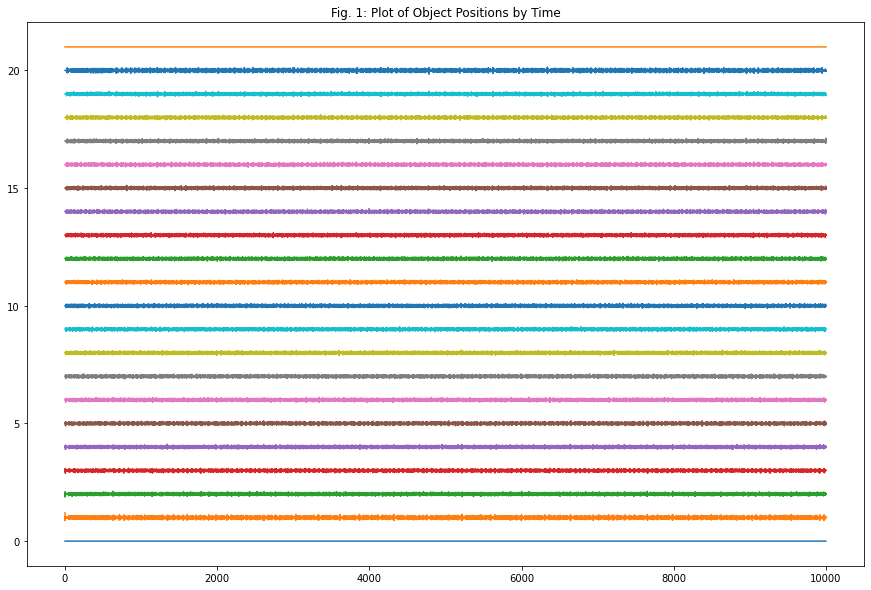

In [10]:
objects[1].displace(0.2, 0)

min_pos = []
max_vel = []
rel_pos = []
rel_vel = []
for i in range(len(objects) - 1):
    min_pos.append(99999)
    max_vel.append(-99999)
    rel_pos.append([])
    rel_vel.append([])

for s in springs:
    s.spring_force()
for obj in objects:
    obj.Newton()

time = []
for i in range(iters):
    time.append(i*dt)
    for d in drivers:
        d.drive(i*dt)
    for obj in objects:
        obj.xstep()
    for s in springs:
        s.spring_force()
    for obj in objects:
        obj.vstep()
    for j in range(len(objects) - 1):
        delta_x = objects[j + 1].position - objects[j].position
        delta_v = objects[j].velocity - objects[j + 1].velocity
        if delta_x < min_pos[j]:
            min_pos[j] = delta_x
        if delta_v > max_vel[j]:
            max_vel[j] = delta_v
        rel_pos[j].append(delta_x)
        rel_vel[j].append(delta_v)
        
plt.figure(figsize = (15,10))
plt.title(figLabel(figNum) + "Plot of Object Positions by Time")
figNum += 1

for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Now that we have confirmed the fidelity of our simulation, let us add in the driving force, and take a look at the interaction.

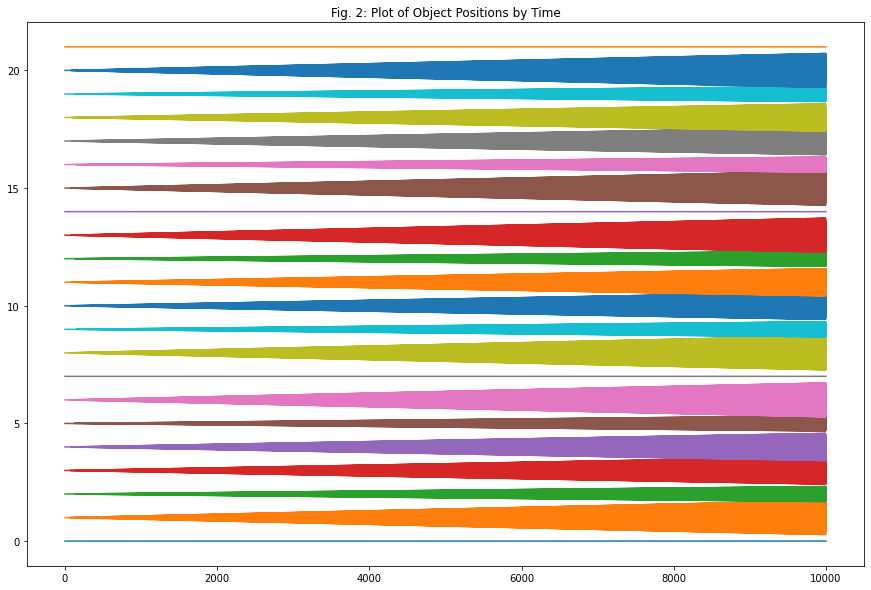

In [11]:
for obj in objects:
    obj.reset()
drivers.append(driver(A, omega, phi, objects[1]))

min_pos = []
max_vel = []
rel_pos = []
rel_vel = []
for i in range(len(objects) - 1):
    min_pos.append(99999)
    max_vel.append(-99999)
    rel_pos.append([])
    rel_vel.append([])

time = []
for i in range(iters):
    time.append(i*dt)
    for d in drivers:
        d.drive(i*dt)
    for obj in objects:
        obj.xstep()
    for s in springs:
        s.spring_force()
    for obj in objects:
        obj.vstep()
    for j in range(len(objects) - 1):
        delta_x = objects[j + 1].position - objects[j].position
        delta_v = objects[j].velocity - objects[j + 1].velocity
        if delta_x < min_pos[j]:
            min_pos[j] = delta_x
        if delta_v > max_vel[j]:
            max_vel[j] = delta_v
        rel_pos[j].append(delta_x)
        rel_vel[j].append(delta_v)
        
plt.figure(figsize = (15,10))
plt.title(figLabel(figNum) + "Plot of Object Positions by Time")
figNum += 1

for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

Let's take a look at the frequency domain of the resulting motion. As we see, we get peaks at the normal modes, but also a peak at the driven frequency. 

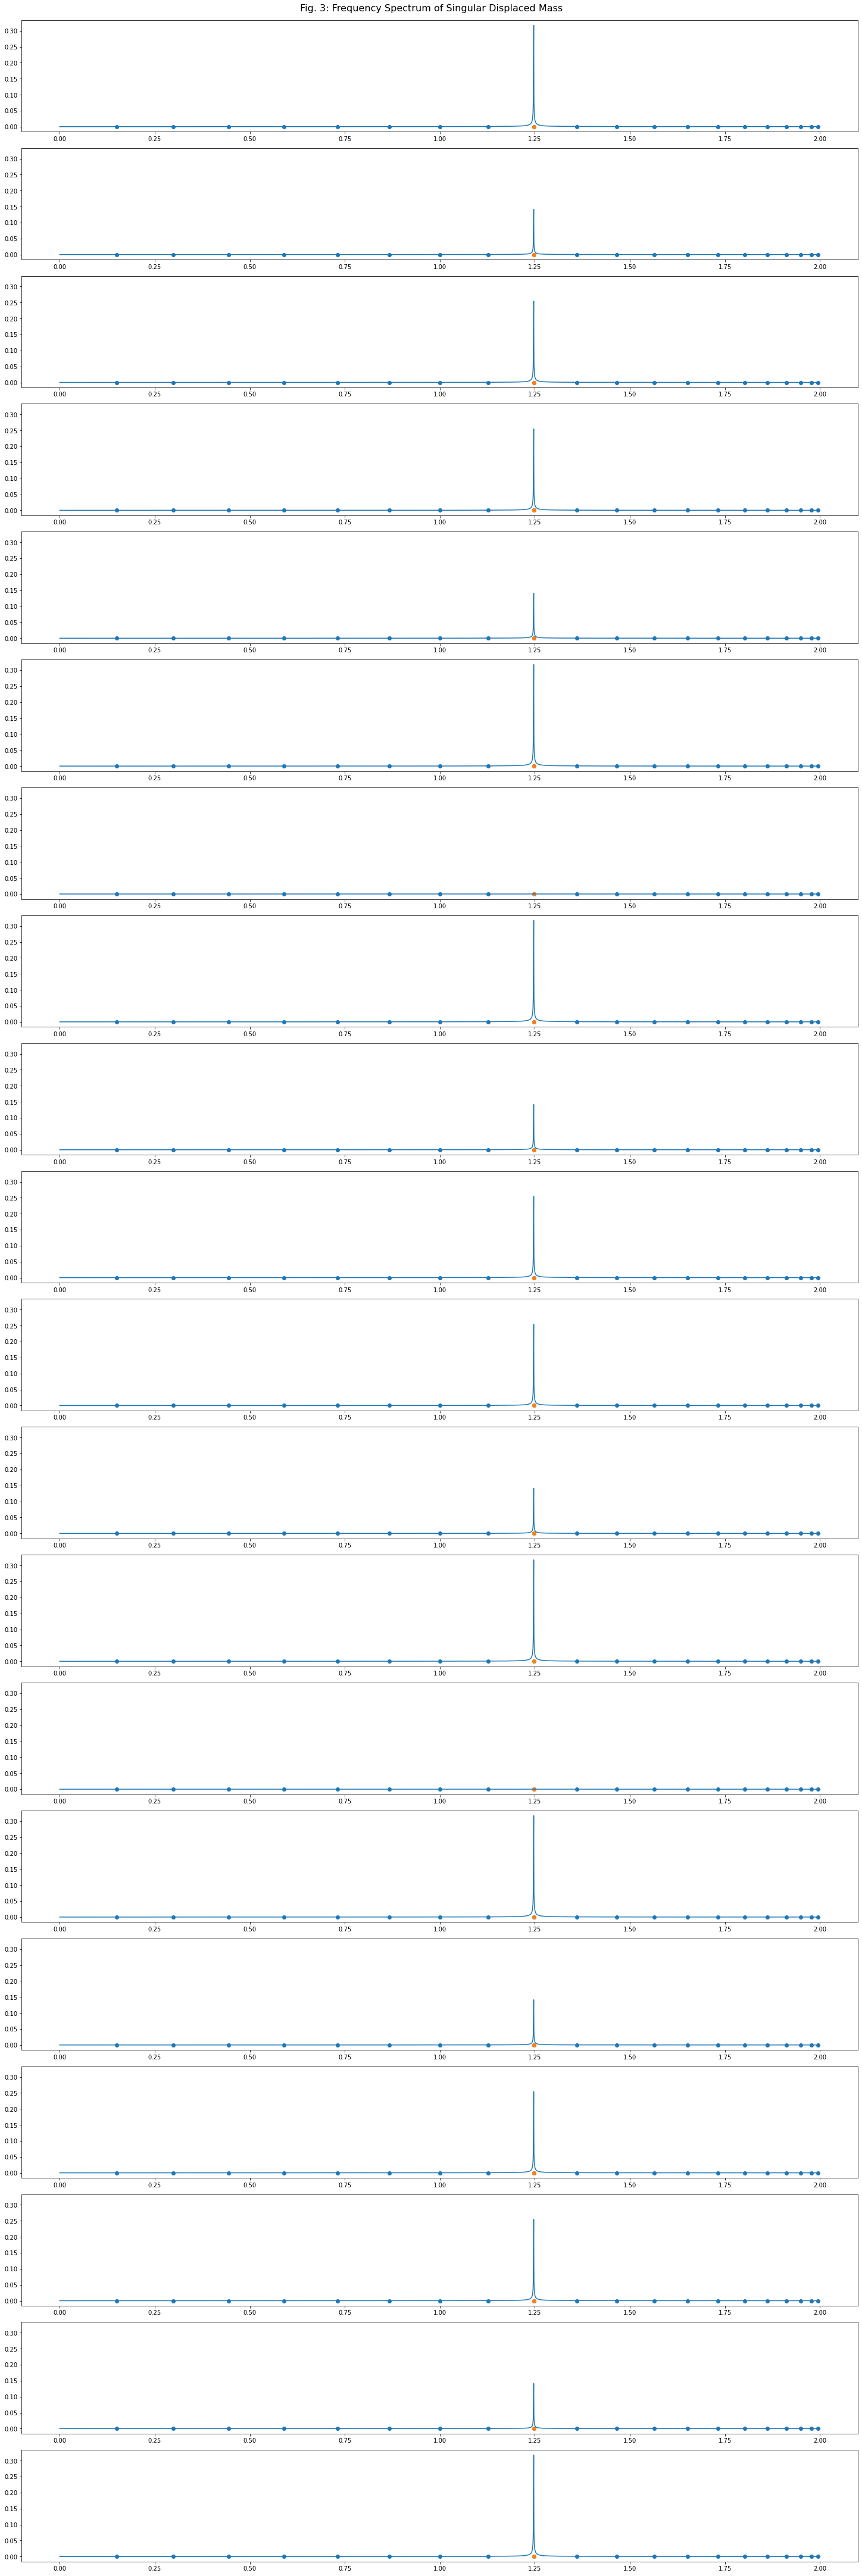

In [12]:
fig, axs = plt.subplots(N, 1, sharey = True, figsize = (20, 3*N), constrained_layout=True)
fig.suptitle(figLabel(figNum) + "Frequency Spectrum of Singular Displaced Mass", fontsize = 16)
figNum += 1

max_freq = 2 / (2 * np.pi)
end_coord = int(max_freq*end_time)
graph = 0

omegas = []
zeros = []
for m in range(1, N + 1):
    freq = np.sqrt(2*k/mass*(1 - np.cos(np.pi*m/(N+1))))
    omegas.append(freq)
    zeros.append(0)

for obj in objects[1:N+1]:
    y = obj.xhistory
    yf = np.fft.fft(y)
    yf = 2/iters * np.abs(yf[:iters//2])
    yf = yf[1:end_coord+1]
    xf = 2*np.pi*np.linspace(0.0, max_freq, end_coord)
    axs[graph].plot(xf, yf)
    axs[graph].scatter(omegas, zeros)
    axs[graph].scatter(omega, [0])
    graph += 1

plt.show()

For comparison purposes, let's print out the theoretical normal modes. As before, they follow the formula:
$$\omega = \sqrt{\frac{2k}{m}\left(1 - \cos\left(\frac{2\pi l}{\lambda}\right)\right)}$$
Where $\lambda$ is constrained to be $\lambda = \frac{2(N+1)l}{n}$ where $N$ is the total number of oscillating masses, and $n$ is an integer. Putting it together,
$$\omega_n = \sqrt{\frac{2k}{m}\left(1 - \cos\left(\frac{n\pi}{N + 1}\right)\right)}$$

In [13]:


read_out = "The theoretical normal modes for this system are: "
for freq in omegas:
    read_out += str(freq) + ", "
print(read_out)

The theoretical normal modes for this system are: 0.14946018717284865, 0.2980845323523487, 0.4450418679126288, 0.5895103488218084, 0.73068204873279, 0.8677674782351161, 0.9999999999999999, 1.1266401161272441, 1.246979603717467, 1.3603454755418387, 1.4661037436596527, 1.5636629649360596, 1.6524775486319898, 1.7320508075688772, 1.801937735804838, 1.8617474972884085, 1.9111456115722816, 1.9498558243636472, 1.977661652450257, 1.9944075943623603, 


Now let's see the relative position and velocity distributions.

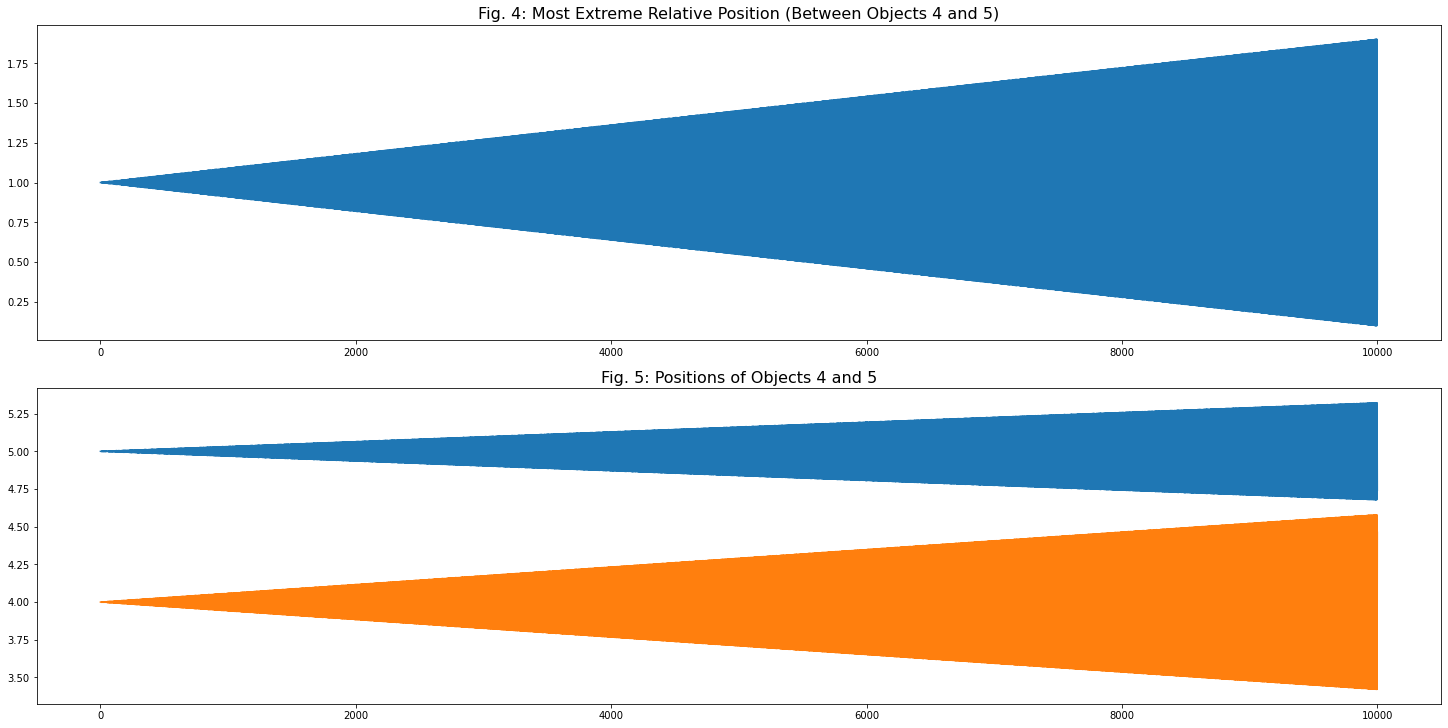

In [14]:
graph = np.argmin(min_pos)
fig, axs = plt.subplots(2, 1, sharey = False, figsize = (20, 10), constrained_layout=True)
axs[0].set_title(figLabel(figNum) + "Most Extreme Relative Position (Between Objects " + str(graph) + " and " + str(graph + 1) + ")", fontsize = 16)
figNum += 1

axs[0].plot(time, rel_pos[graph])
axs[1].set_title(figLabel(figNum) + "Positions of Objects " + str(graph) + " and " + str(graph + 1), fontsize = 16)
figNum += 1
axs[1].plot(time, objects[graph + 1].xhistory)
axs[1].plot(time, objects[graph].xhistory)
plt.show()

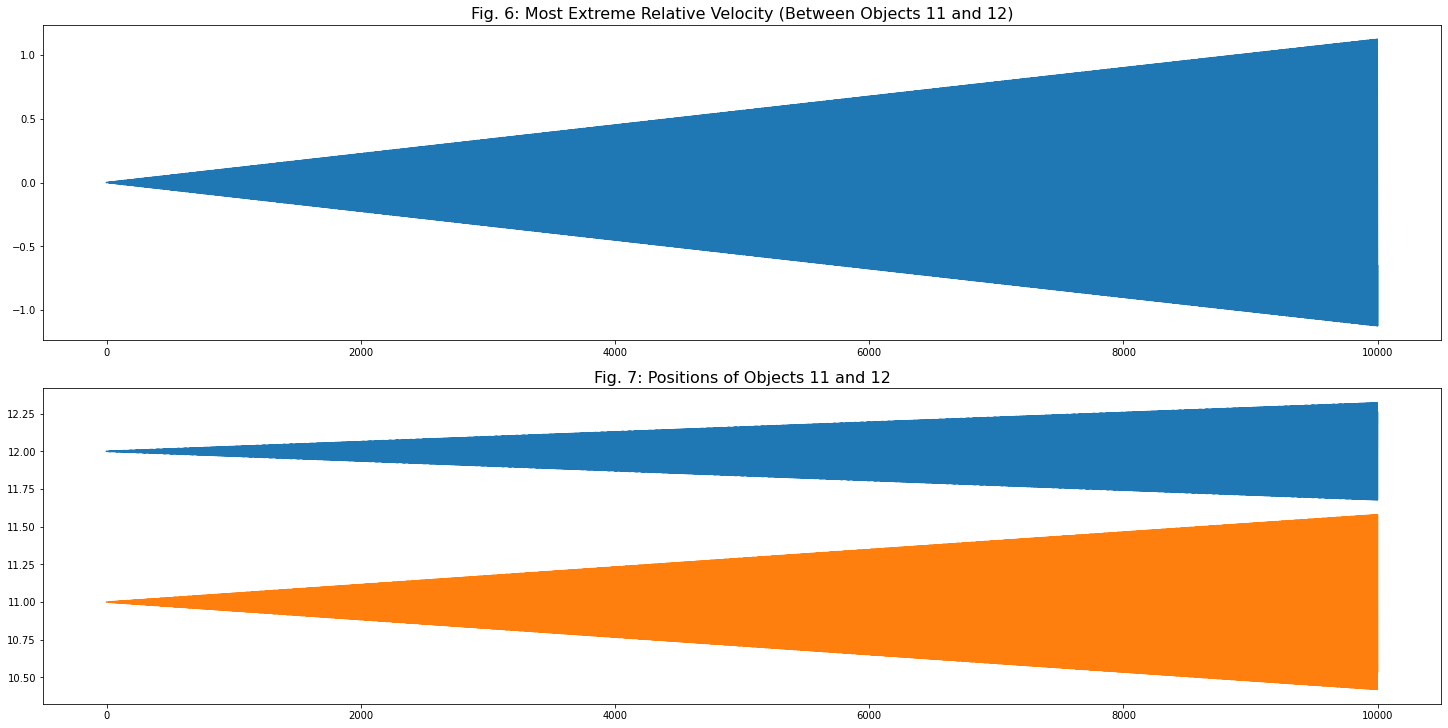

In [15]:
graph = np.argmax(max_vel)
fig, axs = plt.subplots(2, 1, sharey = False, figsize = (20, 10), constrained_layout = True)
axs[0].set_title(figLabel(figNum) + "Most Extreme Relative Velocity (Between Objects " + str(graph) + " and " + str(graph + 1) + ")", fontsize = 16)
figNum += 1

axs[0].plot(time, rel_vel[graph])
axs[1].set_title(figLabel(figNum) + "Positions of Objects " + str(graph) + " and " + str(graph + 1), fontsize = 16)
figNum += 1

axs[1].plot(time, objects[graph + 1].xhistory)
axs[1].plot(time, objects[graph].xhistory)
plt.show()

# Driving Wall

In the paper by Staker, the string was driven by the oscillation of the Pd atom, which in this case is the wall. For this simulation, we are going to see what happens when we drive the system by oscillating the wall.

In [16]:
A = 0.01
omega = 1.246979603717467

phi = 0

objects = []
springs = []
objects.append(wall(x0 = 0))
for n in range(N):
    objects.append(object(mass, x0 = l*(n + 1), dt = dt))
objects.append(wall(x0 = l*(N + 1)))
for m in range(N+1):
    springs.append(spring(k, objects[m], objects[m+1], rest_length = l))

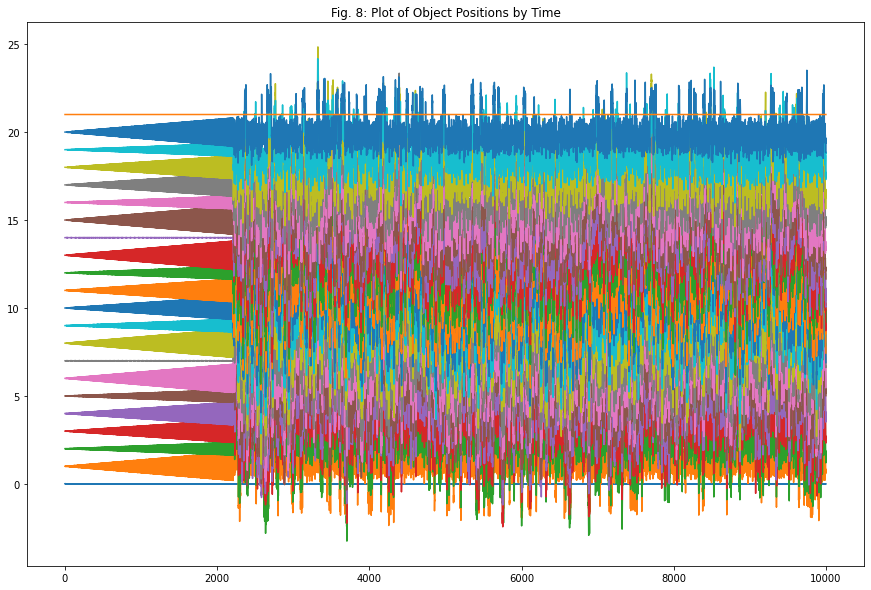

In [17]:
objects[0].setup(A, omega, phi)

min_pos = []
max_vel = []
rel_pos = []
rel_vel = []
for i in range(len(objects) - 1):
    min_pos.append(99999)
    max_vel.append(-99999)
    rel_pos.append([])
    rel_vel.append([])

time = []
for i in range(iters):
    time.append(i*dt)
    objects[0].move(i*dt)
    for obj in objects:
        obj.xstep()
    for s in springs:
        s.spring_force()
    for obj in objects:
        obj.vstep()
    for j in range(len(objects) - 1):
        delta_x = objects[j + 1].position - objects[j].position
        delta_v = objects[j].velocity - objects[j + 1].velocity
        if delta_x < min_pos[j]:
            min_pos[j] = delta_x
        if delta_v > max_vel[j]:
            max_vel[j] = delta_v
        rel_pos[j].append(delta_x)
        rel_vel[j].append(delta_v)
        
plt.figure(figsize = (15,10))
plt.title(figLabel(figNum) + "Plot of Object Positions by Time")
figNum += 1

for obj in objects:
    plt.plot(time, obj.xhistory)
plt.show()

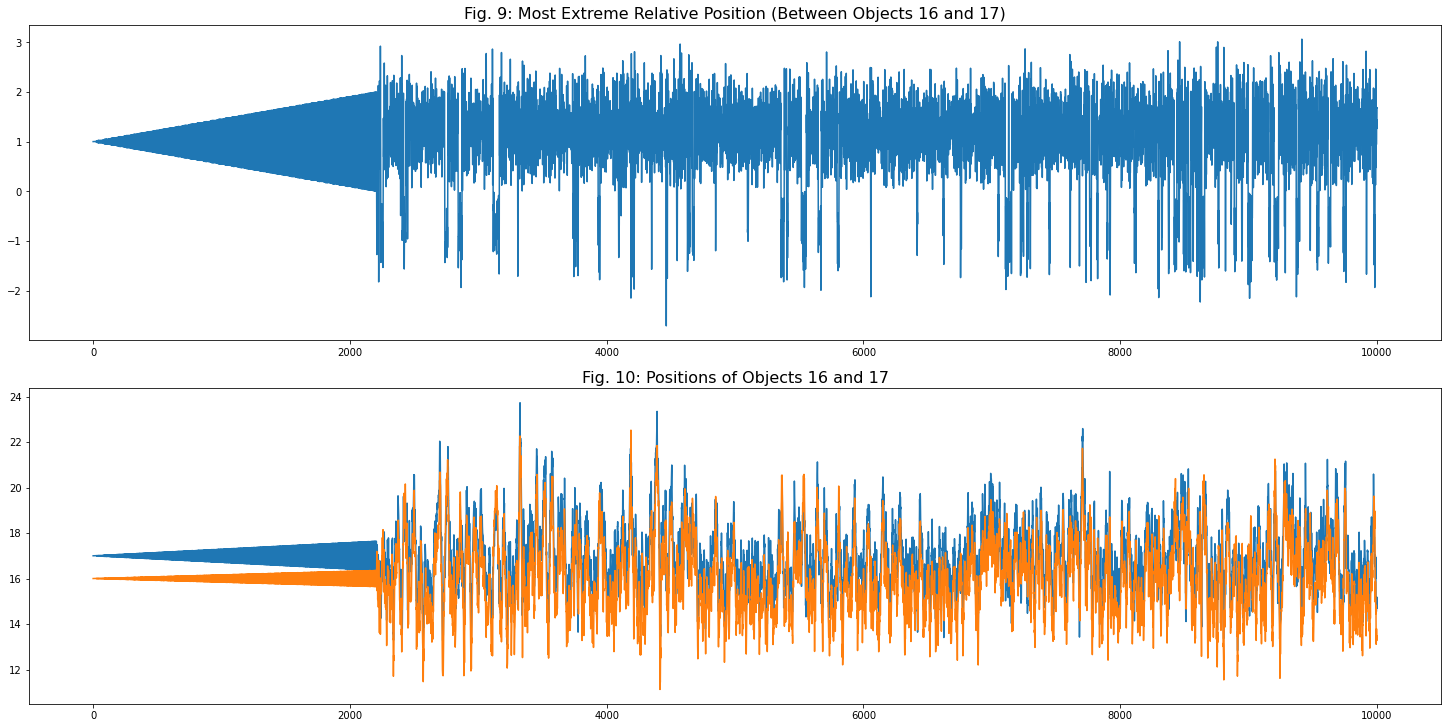

In [18]:
graph = np.argmin(min_pos)
fig, axs = plt.subplots(2, 1, sharey = False, figsize = (20, 10), constrained_layout=True)
axs[0].set_title(figLabel(figNum) + "Most Extreme Relative Position (Between Objects " + str(graph) + " and " + str(graph + 1) + ")", fontsize = 16)
figNum += 1

axs[0].plot(time, rel_pos[graph])
axs[1].set_title(figLabel(figNum) + "Positions of Objects " + str(graph) + " and " + str(graph + 1), fontsize = 16)
figNum += 1
axs[1].plot(time, objects[graph + 1].xhistory)
axs[1].plot(time, objects[graph].xhistory)
plt.show()

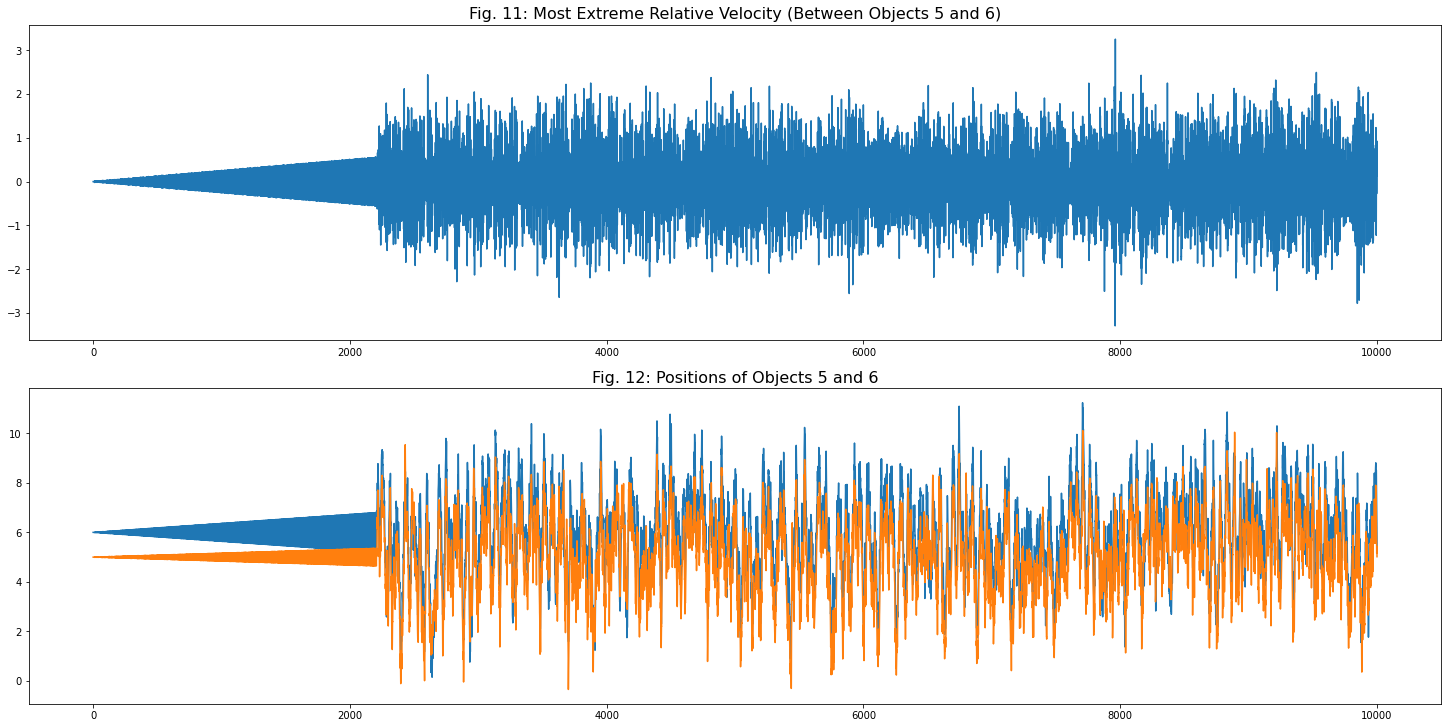

In [19]:
graph = np.argmax(max_vel)
fig, axs = plt.subplots(2, 1, sharey = False, figsize = (20, 10), constrained_layout = True)
axs[0].set_title(figLabel(figNum) + "Most Extreme Relative Velocity (Between Objects " + str(graph) + " and " + str(graph + 1) + ")", fontsize = 16)
figNum += 1

axs[0].plot(time, rel_vel[graph])
axs[1].set_title(figLabel(figNum) + "Positions of Objects " + str(graph) + " and " + str(graph + 1), fontsize = 16)
figNum += 1

axs[1].plot(time, objects[graph + 1].xhistory)
axs[1].plot(time, objects[graph].xhistory)
plt.show()